In [1]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets
from PIL import Image
import matplotlib.pyplot as plt
import json

In [5]:
vgg16 = models.vgg16(pretrained = True)
vgg16.eval()

/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /Users/charlotteimbert/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|████████████████████████████████████████| 528M/528M [00:27<00:00, 20.1MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [7]:
# 2. Load ImageNet labels (1000 class names) so you can decode output
with open('imagenet_classes.txt') as f:
    idx2label = [line.strip() for line in f.readlines()]

# 3. Define transform (resize, normalize)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

In [13]:
# 4. Load one example image from TinyImageNet
img = Image.open('tiny-imagenet-200/val/images/val_0.JPEG').convert('RGB')
img_transformed = transform(img).unsqueeze(0)  # [1, 3, 224, 224]

In [15]:
# 5. Predict
with torch.no_grad():
    output = vgg16(img_transformed)

bobsled: 0.1687
stretcher: 0.0596
snowmobile: 0.0459
thresher: 0.0397
chain saw: 0.0324


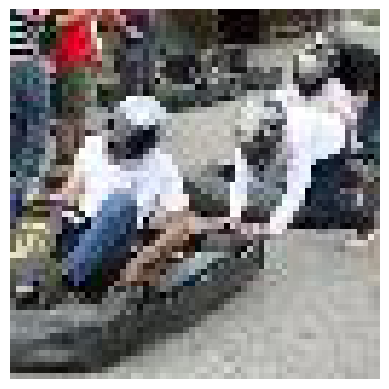

In [17]:
# 6. Decode top-5 predictions
probabilities = torch.nn.functional.softmax(output[0], dim=0)
top5_prob, top5_catid = torch.topk(probabilities, 5)

for i in range(top5_prob.size(0)):
    print(f"{idx2label[top5_catid[i]]}: {top5_prob[i].item():.4f}")

# 7. (Optional) Show the image
plt.imshow(img)
plt.axis('off')
plt.show()

In [19]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import os
import random

# --------- Setup ---------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load pretrained VGG16
vgg16 = models.vgg16(pretrained=True).to(device)
vgg16.eval()

# Load ImageNet class names (download this file if you don't have it)
with open('imagenet_classes.txt') as f:
    idx2label = [line.strip() for line in f.readlines()]

# Load val_annotations.txt to map val images to WNIDs
val_annotations = {}
with open('tiny-imagenet-200/val/val_annotations.txt', 'r') as f:
    for line in f.readlines():
        parts = line.strip().split('\t')
        filename, wnid = parts[0], parts[1]
        val_annotations[filename] = wnid

# Load wnid -> human-readable label from words.txt
wnid_to_label = {}
with open('tiny-imagenet-200/words.txt', 'r') as f:
    for line in f.readlines():
        wnid, label = line.strip().split('\t')
        wnid_to_label[wnid] = label

# Transform for VGG16
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Path to validation images
val_img_dir = 'tiny-imagenet-200/val/images'

# --------- Evaluate ---------
all_val_images = os.listdir(val_img_dir)
sampled_images = random.sample(all_val_images, 50)  # sample 50 random images

correct = 0

for img_file in sampled_images:
    img_path = os.path.join(val_img_dir, img_file)
    img = Image.open(img_path).convert('RGB')
    input_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = vgg16(input_tensor)

    probs = torch.nn.functional.softmax(output[0], dim=0)
    top1_prob, top1_catid = torch.topk(probs, 1)

    pred_label = idx2label[top1_catid.item()]
    true_wnid = val_annotations[img_file]
    true_label = wnid_to_label.get(true_wnid, 'unknown')

    print(f"Image: {img_file}")
    print(f"True: {true_label}")
    print(f"Pred: {pred_label} ({top1_prob.item():.4f})")
    print("-" * 40)

    # Quick matching heuristic: check if true label *word* appears inside pred_label
    if true_label.split(',')[0].lower() in pred_label.lower():
        correct += 1

print(f"\nRough Top-1 Match Accuracy: {correct}/{len(sampled_images)} = {correct/len(sampled_images):.2%}")


Image: val_4861.JPEG
True: European fire salamander, Salamandra salamandra
Pred: European fire salamander (0.3545)
----------------------------------------
Image: val_7057.JPEG
True: crane
Pred: steel arch bridge (0.4083)
----------------------------------------
Image: val_5973.JPEG
True: chain
Pred: chain (0.3870)
----------------------------------------
Image: val_1411.JPEG
True: seashore, coast, seacoast, sea-coast
Pred: grey whale (0.3463)
----------------------------------------
Image: val_8117.JPEG
True: picket fence, paling
Pred: worm fence (0.3258)
----------------------------------------
Image: val_1219.JPEG
True: kimono
Pred: overskirt (0.1684)
----------------------------------------
Image: val_8887.JPEG
True: slug
Pred: tailed frog (0.3902)
----------------------------------------
Image: val_7359.JPEG
True: ladybug, ladybeetle, lady beetle, ladybird, ladybird beetle
Pred: ant (0.4878)
----------------------------------------
Image: val_8233.JPEG
True: pole
Pred: worm fence 

In [ ]:
# --- IMPORTS ---
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.transforms.functional import rgb_to_grayscale
from PIL import Image
import os
import numpy as np
import pandas as pd
from collections import defaultdict

# --- DEVICE SETUP ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- LOAD MODEL ---
vgg16 = models.vgg16(pretrained=True).to(device)
vgg16.eval()

# --- SETUP HOOKS ---
activations = {}

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Hook conv layers
for idx, layer in enumerate(vgg16.features):
    if isinstance(layer, torch.nn.Conv2d):
        layer.register_forward_hook(get_activation(f'conv{idx}'))

# --- TRANSFORMS ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def to_grayscale(img_tensor):
    return rgb_to_grayscale(img_tensor, num_output_channels=3)

# --- FUNCTIONS ---

def gather_color_activations(image_paths):
    """
    Pass images through VGG16 and store mean activations per neuron.
    """
    color_acts = defaultdict(lambda: defaultdict(list))

    for img_path in image_paths:
        img = Image.open(img_path).convert('RGB')
        img_tensor = transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            vgg16(img_tensor)

        for layer_name, act in activations.items():
            mean_act = act.mean(dim=[0, 2, 3]).squeeze(0).cpu().numpy()  # [channels]
            for neuron_idx, act_val in enumerate(mean_act):
                color_acts[layer_name][neuron_idx].append((img_path, act_val))

    return color_acts

def compute_true_csi(color_acts, top_n=50):
    """
    Given color activations, compute true CSI based on top-N images per neuron.
    """
    true_csi = defaultdict(dict)

    for layer_name, neurons in color_acts.items():
        for neuron_idx, img_act_list in neurons.items():
            # Sort images by activation strength (highest first)
            img_act_list = sorted(img_act_list, key=lambda x: x[1], reverse=True)

            top_imgs = [img for img, _ in img_act_list[:top_n]]

            sum_color = 0
            sum_gray = 0

            for img_path in top_imgs:
                img = Image.open(img_path).convert('RGB')
                img_tensor = transform(img).unsqueeze(0).to(device)
                input_gray = to_grayscale(transform(img)).unsqueeze(0).to(device)

                with torch.no_grad():
                    vgg16(img_tensor)
                    color_mean = activations[layer_name].mean(dim=[0, 2, 3])[0, neuron_idx]

                    vgg16(input_gray)
                    gray_mean = activations[layer_name].mean(dim=[0, 2, 3])[0, neuron_idx]

                sum_color += color_mean.item()
                sum_gray += gray_mean.item()

            csi = 1 - (sum_gray / (sum_color + 1e-8))
            true_csi[layer_name][neuron_idx] = csi

    return true_csi

In [ ]:
def compute_activation_curve(img_paths, transform_func, steps, layer_name, neuron_idx):
    """
    Pass top-N images with perturbations and compute mean activation at each step.
    """
    responses = []

    for s in steps:
        step_activations = []
        for img_path in img_paths:
            img = Image.open(img_path).convert('RGB')
            img_transformed = transform_func(img, s)
            input_tensor = transform(img_transformed).unsqueeze(0).to(device)

            with torch.no_grad():
                vgg16(input_tensor)

            mean_act = activations[layer_name].mean(dim=[0, 2, 3])[0, neuron_idx]
            step_activations.append(mean_act.item())

        mean_response = np.mean(step_activations)
        responses.append(mean_response)

    return responses

def plot_activation_curve(responses, steps, layer_name, neuron_idx):
    plt.figure(figsize=(6,4))
    plt.plot(steps, responses, marker='o')
    plt.title(f'Neuron {neuron_idx} in {layer_name}\nResponse Curve')
    plt.xlabel('Perturbation')
    plt.ylabel('Mean Activation')
    plt.grid(True)
    plt.show()

In [ ]:
def save_csi_to_csv(true_csi, output_path='csi_results.csv'):
    """
    Save true CSI results into a clean CSV file.
    Each row = one neuron (layer, neuron_idx, CSI value).
    """
    records = []

    for layer_name, neurons in true_csi.items():
        for neuron_idx, csi_value in neurons.items():
            records.append({
                'layer': layer_name,
                'neuron_idx': neuron_idx,
                'csi': csi_value
            })

    df = pd.DataFrame(records)
    df.to_csv(output_path, index=False)
    print(f"Saved CSI results to {output_path}")

In [ ]:
df = pd.read_csv('csi_results.csv')

# Mean CSI per layer
mean_csi = df.groupby('layer')['csi'].mean()
print(mean_csi)

# Histogram of CSI for a specific layer
import matplotlib.pyplot as plt

layer = 'conv5'
df_layer = df[df['layer'] == layer]

plt.hist(df_layer['csi'], bins=20)
plt.title(f'CSI Distribution in {layer}')
plt.xlabel('CSI')
plt.ylabel('Number of Neurons')
plt.grid(True)
plt.show()